### Bayes MCMC and Covariance Matrix

Bayes Monte Carlo Markov Chain (MCMC) as implemented in Sherpa explores parameter space at a suspected minimum - i.e. after a standard Sherpa fit with a selected optimization method. The chains are run using `get_draws()` function with the multivariate t-distribution as the proposal distribution. t-distribution is defined using multivariate normal and chi2 distributions and it coverges to normal for a high degrees-of-freedom. It has heavier tails than the normal distribution which assures a good span of sampled parameters.   The multivariate normal distribution requires the best-fit parameter values and the corresponding covariance matrix and `covar()` should be run beforehand.

This notebook shows a simple case for a well defined covariance matrix. It also describes how the covariance matrix can be approximated if the `covar()` fails to calculate valid covariance matrix in such cases as bad quality data, upper/lower bounds on best-fit parameters, wrong model etc.

The first example is just a standard simple fit to a good quality X-ray spectrum.

This notebook was run in CIAO 4.13


First import Sherpa 

In [1]:
from sherpa.astro.ui import *

Set Poisson likelihood statistics called `cash` and select `simplex` as an optimization method for the initial fit. `simplex` method nelder-mead algorithm.

In [2]:
set_stat('cash')
set_method('neldermead')

Next load the data, filter and setup a simple absorbed power law model. Note that the calibration files, ARF and RMF,  which are needed for the X-ray analysis and a background fileare read and when the file "acis.pi" is loaded into the session. 

In [3]:
load_data("acis.pi")

read ARF file acis.arf
read RMF file acis.rmf
read background file acis_bg.pi


In [4]:
#Filter data for fitting - use only energy between 0.4-8 keV
ignore(":0.4,8.0:")
# set model for fitting the spectra - we use the absorbed power law model, with Galactic NH parameter frozen
set_model(xsphabs.abs1*xszphabs.zabs1*xspowerlaw.p1)
# set and freeze Galactic NH 
set_par(abs1.nh, 0.0383)
freeze(abs1.nh)
zabs1.redshift=0.312

Run the initial fit using simplex and cash. This returns the best fit model parameters, absorption column, power law photon index and normalization.

In [5]:
fit()

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 4.00019e+07
Final fit statistic   = -91853.5 at function evaluation 547
Data points           = 519
Degrees of freedom    = 516
Change in statistic   = 4.00938e+07
   zabs1.nH       0.0868846   
   p1.PhoIndex    1.20713     
   p1.norm        0.000552677 


Next get the covariance matrix with covar(). The matrix is later used in the MCMC run.

In [6]:
covar()

Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cash
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   zabs1.nH        0.0868846  -0.00945653   0.00945653
   p1.PhoIndex       1.20713   -0.0200537    0.0200537
   p1.norm       0.000552677 -1.10349e-05  1.10349e-05


Plot the model and the data. 

There are a few samplers in Sherpa that can be used to explore the parameter space. The standard "metropolismh" runs MCMC with Metropolis-Metropolis-Hastings criterium for accepting parameters.

In [7]:
list_samplers()

['metropolismh', 'mh', 'pragbayes', 'fullbayes']

Select MetropolisMH and check the options:

In [8]:
set_sampler("MetropolisMH")
#get_sampler()

Here we list several options for running the MCMC sampler: 

defaultprior – indicates that all parameters have the default flat prior

inv – indicates which parameters on the inverse scale.

log – indicates which parameters are on the logarithm scale (natural log).

originalscale –  shows that the parameters are on the original scale.

p_M – the proportion of jumps generated by the MCMC jumping rule.

priorshape –  indicates which parameters have user-defined prior functions.

scale – A scalar multiple of the output of covar() used in the scale of the t-distribution


We first run the MCMC with the default settings:

In [9]:
stats, accept, params = get_draws(niter=5e3)
# check the parameters at the minimum statistic value based on the sampler:

Using Priors:
zabs1.nH: <function flat at 0x7f84f2354700>
p1.PhoIndex: <function flat at 0x7f84f2354700>
p1.norm: <function flat at 0x7f84f2354700>


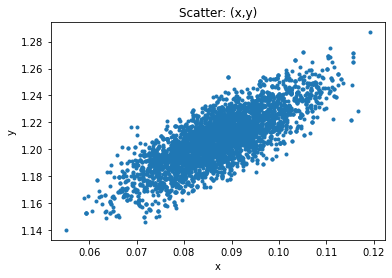

In [10]:
# dependence between parameters
plot_scatter(params[0],params[1])

In [11]:
#plot_pdf(params[1])

In [12]:
#plot_cdf(params[1])
#print(get_cdf_plot().median)
#print(get_cdf_plot().upper)
#print(get_cdf_plot().lower)      

### Effects of Priors

Changing the prior - here an example of prior which has a gaussian shape. We use one of the predefined Sherpa models to set the prior.

In [13]:
normgauss1d.g1
g1.pos=2.
g1.fwhm=0.5
set_prior(p1.PhoIndex,g1)

In [14]:
set_sampler_opt('defaultprior',False)  
set_sampler_opt('priorshape', [False, True, False])  
set_sampler_opt('originalscale', [True, True, True])

In [15]:
#Run sampler
stats1, accept1, params1 = get_draws(niter=5e3)

Using Priors:
zabs1.nH: <function flat at 0x7f84f2354700>
p1.PhoIndex: normgauss1d.g1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   g1.fwhm      thawed          0.5  1.17549e-38  3.40282e+38           
   g1.pos       thawed            2 -3.40282e+38  3.40282e+38           
   g1.ampl      thawed            1 -3.40282e+38  3.40282e+38           
p1.norm: <function flat at 0x7f84f2354700>


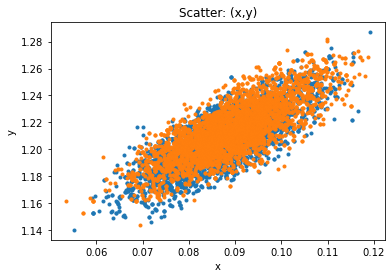

In [16]:
#plot_trace(params[1])
plot_scatter(params[0],params[1])
plot_scatter(params1[0],params1[1],overplot=True)

# What if a calculation of covariance matrix fails?


If the best fit parameters are not at the best-fit minimum or the model applied to the data is incorrect the calculation of the covariance matrix will fail. The failure can also occur if the parameter is not well constrained by the data and only the upper or lower bound is found. In such a case the check whether the supplied matrix is valid (must be symmetric and positive-semidefinite `numpy.random.multivariate_normal`) will end with error.

One solution to this is to supply the matrix to `get_draws()` using `covar_matrix` argument, which is by default set to `None` and calculated by `covar()` internally.

`get_draws(id=None, otherids=(), niter=1000, covar_matrix=None)`

In the case of failed checks for the validity of covariance matrix one could use `conf()` to calculated the parameter errors and supply the result in a form of diagonal matrix. This approximation results in a less efficient sampling and low acceptance rates. Thus `niter` has to be large to obtain an adequate number of accepted draws.


In [17]:
covar()

Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cash
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   zabs1.nH        0.0868846  -0.00945653   0.00945653
   p1.PhoIndex       1.20713   -0.0200537    0.0200537
   p1.norm       0.000552677 -1.10349e-05  1.10349e-05


In this case the `covar()` results in a valid covariance matrix accessed with `extra_output` the same as above. The diagonal elements can be defined using numpy.

In [18]:
print(get_covar_results().extra_output)

[[8.94260313e-05 1.48942985e-04 8.98691315e-08]
 [1.48942985e-04 4.02150817e-04 1.92064287e-07]
 [8.98691315e-08 1.92064287e-07 1.21768926e-10]]


In [19]:
import numpy as np
d = np.diag(get_covar_results().extra_output)
print(d)

[8.94260313e-05 4.02150817e-04 1.21768926e-10]


Define `cov_mat` using the diagonal elements from `covar()` and enter into `get_draws()`.

In [20]:
print(d[0],d[1],d[2])
cov_mat = np.array([[d[0],0,0],[0,d[1],0],[0.,0.,d[2]]])

8.942603129905809e-05 0.00040215081690224414 1.2176892578477748e-10


In [21]:
print(cov_mat)

[[8.94260313e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.02150817e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.21768926e-10]]


In [22]:
stat2, accept2, params2 = get_draws(1,niter = 5000, covar_matrix=cov_mat)

Using Priors:
zabs1.nH: <function flat at 0x7f84f2354700>
p1.PhoIndex: normgauss1d.g1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   g1.fwhm      thawed          0.5  1.17549e-38  3.40282e+38           
   g1.pos       thawed            2 -3.40282e+38  3.40282e+38           
   g1.ampl      thawed            1 -3.40282e+38  3.40282e+38           
p1.norm: <function flat at 0x7f84f2354700>


Compare the results of the three different cases. Note that params1 and params2 (orange, green) have the same gaussian prior while params (blue) assumed a flat prior.

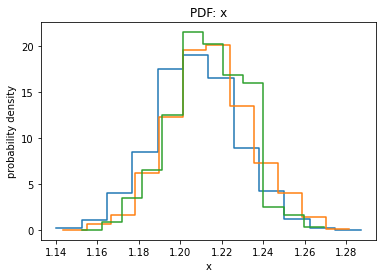

In [23]:
plot_pdf(params[1])
plot_pdf(params1[1], overplot=True)
plot_pdf(params2[1],overplot=True)

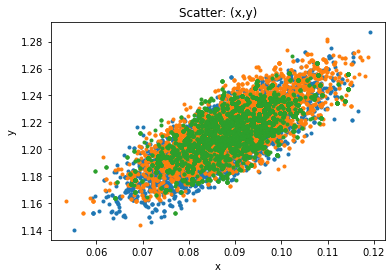

In [24]:
plot_scatter(params[0],params[1])
plot_scatter(params1[0],params1[1],overplot=True)
plot_scatter(params2[0],params2[1],overplot=True)

In [25]:
conf()

zabs1.nH lower bound:	-0.00945653
zabs1.nH upper bound:	0.00945653
p1.PhoIndex lower bound:	-0.0200537
p1.PhoIndex upper bound:	0.0200537
p1.norm lower bound:	-1.08625e-05
p1.norm upper bound:	1.12073e-05
Dataset               = 1
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   zabs1.nH        0.0868846  -0.00945653   0.00945653
   p1.PhoIndex       1.20713   -0.0200537    0.0200537
   p1.norm       0.000552677 -1.08625e-05  1.12073e-05


In [23]:
covar()

Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cash
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   zabs1.nH        0.0868846  -0.00945653   0.00945653
   p1.PhoIndex       1.20713   -0.0200537    0.0200537
   p1.norm       0.000552677 -1.10349e-05  1.10349e-05


 `conf()` and `covar()` shows slight difference in the bounds for `p1.norm`. 1 sigma bounds from the sampler can be compared to these values. For photon index the bounds in the two cases with the same gausian prior and difference in the covariance matrix are plotted with `plot_cdf()`

1.2141822077735493
1.2345172758315834
1.195384780878678
1.2138478952828937
1.2331275079772026
1.1953827076965178


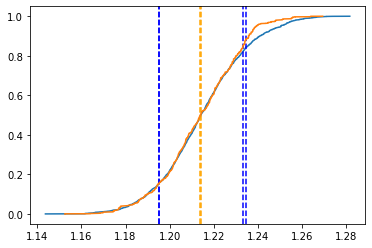

In [28]:
plot_cdf(params1[1], overplot=True)
print(get_cdf_plot().median)
print(get_cdf_plot().upper)
print(get_cdf_plot().lower)
plot_cdf(params2[1], overplot=True)
print(get_cdf_plot().median)
print(get_cdf_plot().upper)
print(get_cdf_plot().lower)  